<a href="https://colab.research.google.com/github/siva9876-tech/AtliQ_Hotel_Data_Analysis_Project/blob/main/Trader_Behavior_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1)Quick setup (imports + safe column normalization)

In [130]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
sns.set(style="whitegrid")

# normalize column names to simple tokens
def normalize_cols(df):
    df = df.copy()
    df.columns = [c.strip().replace(' ', '_').replace('.', '').lower() for c in df.columns]
    return df

trades = normalize_cols(pd.read_csv(r'/content/historical_data.csv'))
sent = normalize_cols(pd.read_csv(r'/content/fear_greed_index.csv'))

/tmp/ipython-input-131931963.py:16: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = normalize_cols(pd.read_csv(r'/content/historical_data.csv'))


2)Preprocess timestamps so both datasets align on daily level

In [131]:
import pytz
kst = 'Asia/Kolkata'

# 1. Prefer numeric epoch column if available
if 'timestamp' in trades.columns:
    max_ts = trades['timestamp'].max()
    unit = 'ms' if max_ts > 1e11 else 's'   # heuristic: >1e11 -> milliseconds
    trades['dt_utc'] = pd.to_datetime(trades['timestamp'], unit=unit, utc=True)
else:
    # fallback parse the human-readable column
    trades['dt_utc'] = pd.to_datetime(trades['timestamp_ist'], errors='coerce').dt.tz_localize('Asia/Kolkata', ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')

# convert to Asia/Kolkata and extract date
trades['dt_ist'] = trades['dt_utc'].dt.tz_convert(kst)
trades['trade_date'] = trades['dt_ist'].dt.date   # datetime.date objects (YYYY-MM-DD)

# normalize sentiment date
sent['date'] = pd.to_datetime(sent['date']).dt.date


3)Filter / focus

In [132]:
# quick filter: any symbol containing 'BTC' (case-insensitive)
trades['coin'] = trades['coin'].astype(str)
btc_trades = trades[trades['coin'].str.contains('BTC', case=False, na=False)].copy()

4)Compute daily PnL per account & overall

In [133]:
trades = trades.fillna({'fee': 0})
trades['net_pnl'] = trades['closed_pnl'] - trades['fee']

# account-day aggregation
acct_day = trades.groupby(['account', 'trade_date']).agg(
    net_pnl_sum = ('net_pnl','sum'),
    n_trades = ('net_pnl','size'),
    avg_trade_pnl = ('net_pnl','mean'),
    avg_size_usd = ('size_usd','mean'),
    long_trades = ('side', lambda s: (s.str.upper()=='BUY').sum()),
    short_trades = ('side', lambda s: (s.str.upper()=='SELL').sum())
).reset_index()

# winner flag per account-day
acct_day['is_winner'] = acct_day['net_pnl_sum'] > 0
acct_day['is_loser']  = acct_day['net_pnl_sum'] < 0

daily = acct_day.groupby('trade_date').agg(
    total_net_pnl = ('net_pnl_sum','sum'),
    mean_account_pnl = ('net_pnl_sum','mean'),
    median_account_pnl = ('net_pnl_sum','median'),
    n_active_accounts = ('account','nunique'),
    total_trades = ('n_trades','sum'),
    win_rate_accounts = ('is_winner','mean')
).reset_index()


5)Identify distribution of winners/losers by day

<Axes: >

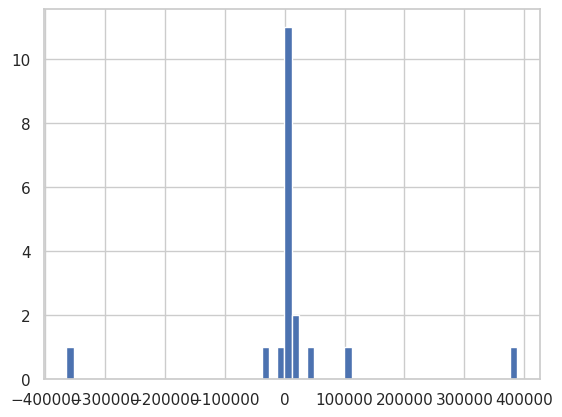

In [134]:
# per-day counts
win_counts = acct_day.groupby('trade_date')['is_winner'].sum().rename('n_winners')
loss_counts = acct_day.groupby('trade_date')['is_loser'].sum().rename('n_losers')
per_day_counts = pd.concat([win_counts, loss_counts], axis=1).fillna(0)
per_day_counts['pct_winners'] = per_day_counts['n_winners'] / (per_day_counts['n_winners'] + per_day_counts['n_losers'])

# visualize distribution on a sample day
sample_date = per_day_counts.index.max()
acct_day[acct_day['trade_date'] == sample_date]['net_pnl_sum'].hist(bins=60)


6)Merge with sentiment data: match daily trades with sentiment index

In [135]:
# merge to market-level
daily = daily.merge(sent[['date','value','classification']], left_on='trade_date', right_on='date', how='left')

# merge to account-level
acct_day = acct_day.merge(sent[['date','value','classification']], left_on='trade_date', right_on='date', how='left')


7)Analysis & Insights — concrete analyses to run

A) Basic compare: Fear vs Greed

In [136]:
daily.groupby('classification').agg(
    mean_total_net_pnl = ('total_net_pnl','mean'),
    median_total_net_pnl = ('total_net_pnl','median'),
    mean_win_rate = ('win_rate_accounts','mean'),
    days = ('trade_date','count')
).sort_values('days', ascending=False)


,mean_total_net_pnl,median_total_net_pnl,mean_win_rate,days
classification,,,,
Greed,9.186107e+05,0.000000e+00,0.291667,3
Neutral,2.729864e+06,2.729864e+06,0.730159,2
Extreme Greed,1.701527e+05,1.701527e+05,0.200000,1


B) Statistical significance

In [137]:
greed = daily[daily['classification'].str.contains('Greed', na=False)]['total_net_pnl']
fear  = daily[daily['classification'].str.contains('Fear', na=False)]['total_net_pnl']

stat, p = stats.mannwhitneyu(greed.dropna(), fear.dropna(), alternative='two-sided')
print('Mann-Whitney p-value', p)


Mann-Whitney p-value nan


/tmp/ipython-input-940847871.py:4: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = stats.mannwhitneyu(greed.dropna(), fear.dropna(), alternative='two-sided')


C) Correlation & lag analysis

In [138]:
daily['value'] = daily['value'].astype(float)
pearson = daily[['value','total_net_pnl']].corr().iloc[0,1]

# lagged correlation (sentiment -> pnl)
for lag in range(0,8):
    corr = daily['total_net_pnl'].corr(daily['value'].shift(lag))
    print(lag, corr)


0 -0.2611264500251644
1 0.16944468680189653
2 -0.24768178522821113
3 0.9126696462401688
4 -0.8489041978226669
5 -0.9999999999999999
6 nan
7 nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


D) Rolling trends (7/14 day)

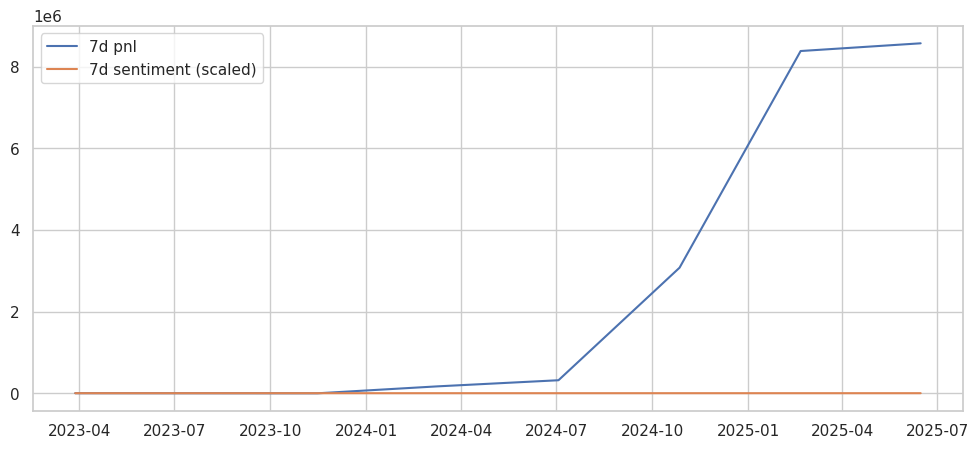

In [139]:
daily['sent_7d'] = daily['value'].rolling(7, min_periods=1).mean()
daily['pnl_7d']  = daily['total_net_pnl'].rolling(7, min_periods=1).sum()

plt.figure(figsize=(12,5))
plt.plot(daily['trade_date'], daily['pnl_7d'], label='7d pnl')
plt.plot(daily['trade_date'], daily['sent_7d'], label='7d sentiment (scaled)')
plt.legend()


E) Leverage / risk-taking changes with sentiment

In [140]:
if 'size_usd' in trades.columns and 'start_position' in trades.columns:
    trades['est_leverage'] = trades['size_usd'] / trades['start_position'].replace(0, np.nan)

    acct_day = acct_day.merge(
        trades.groupby(['account','trade_date'])['est_leverage'].mean().reset_index(),
        on=['account','trade_date'], how='left'
    )

    leverage_daily = (
        acct_day.groupby('trade_date')['est_leverage'].mean().reset_index()
        .merge(sent[['date','classification','value']],
               left_on='trade_date', right_on='date', how='left')
    )

    print(leverage_daily.groupby('classification')['est_leverage'].describe())
else:
    print("⚠️ Cannot derive leverage (needed columns missing).")


                count          mean           std           min           25%  \
classification                                                                  
Extreme Greed     1.0 -2.211180e+04           NaN -22111.796155 -2.211180e+04   
Greed             3.0  2.553390e+05  3.792747e+05   1191.326187  3.736270e+04   
Neutral           2.0  3.384986e+06  4.787994e+06   -636.651075  1.692175e+06   

                         50%           75%           max  
classification                                            
Extreme Greed  -2.211180e+04 -2.211180e+04 -2.211180e+04  
Greed           7.353407e+04  3.824128e+05  6.912915e+05  
Neutral         3.384986e+06  5.077798e+06  6.770610e+06  


F) Cohort analysis: which traders do best in which sentiment regimes?

In [141]:
# account-level historical stats
acct_stats = acct_day.groupby('account').agg(
    total_pnl = ('net_pnl_sum','sum'),
    overall_win_rate = ('is_winner','mean'),
    activity_days = ('trade_date','count'),
    avg_trade_size = ('avg_size_usd','mean')
).reset_index()

# create cohorts by quantiles
acct_stats['activity_q'] = pd.qcut(acct_stats['activity_days'], 4, labels=False, duplicates='drop') # Added duplicates='drop'
acct_stats['pnl_q'] = pd.qcut(acct_stats['total_pnl'].rank(method='first'), 5, labels=False)

print("acct_stats DataFrame:")
print(acct_stats.head())

# Drop existing cohort columns from acct_day if they exist
acct_day = acct_day.drop(columns=['activity_q', 'pnl_q'], errors='ignore')

# merge cohort tags back to acct_day
acct_day = acct_day.merge(acct_stats[['account','activity_q','pnl_q']], on='account', how='left', suffixes=('_x', '_y'))

print("\nacct_day DataFrame after merge:")
print(acct_day.head())

# Handle potential NaN values in 'classification' before grouping
acct_day['classification'] = acct_day['classification'].fillna('Unknown')


# compute cohort performance per sentiment classification
cohort_perf = acct_day.groupby(['pnl_q','classification']).agg(
    mean_net_pnl=('net_pnl_sum','mean'),
    median_net_pnl=('net_pnl_sum','median'),
    win_rate=('is_winner','mean')
).reset_index()


acct_stats DataFrame:
                                      account     total_pnl  overall_win_rate  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  1.592825e+06          0.500000   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  4.515548e+04          1.000000   
2  0x28736f43f1e871e6aa8b1148d38d4994275d72c4  1.302464e+05          1.000000   
3  0x2c229d22b100a7beb69122eed721cee9b24011dd  1.655498e+05          1.000000   
4  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891 -3.135067e+04          0.285714   

   activity_days  avg_trade_size  activity_q  pnl_q  
0              2    15578.066879           0      4  
1              3     1906.523328           1      1  
2              3      371.603235           1      2  
3              3     2229.651440           1      3  
4              7     4641.725901           2      0  

acct_day DataFrame after merge:
                                      account  trade_date   net_pnl_sum  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-10-27 -

Average Win Rate by Classification:
  classification  win_rate
0  Extreme Greed  0.166667
1          Greed  0.800000
2        Neutral  0.819048
3        Unknown  0.766667


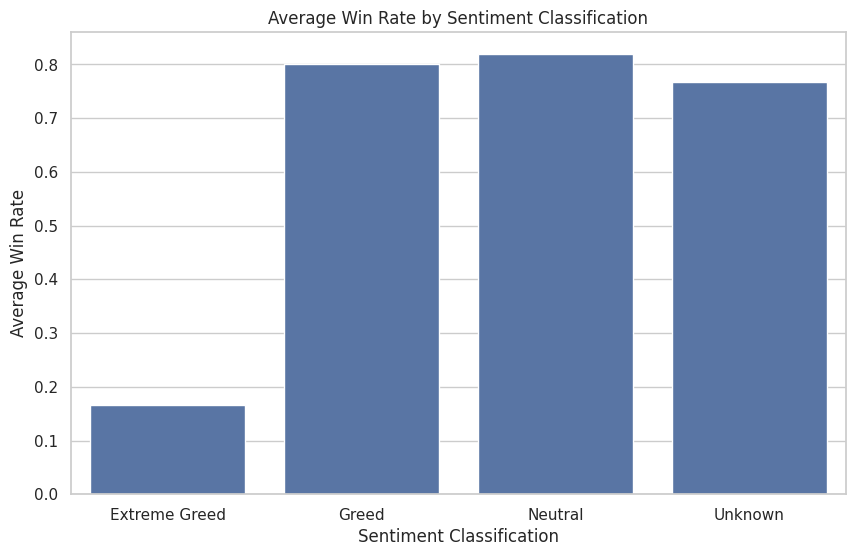

In [142]:
cohort_perf_win_rate = cohort_perf.groupby('classification')['win_rate'].mean().reset_index()
print("Average Win Rate by Classification:")
print(cohort_perf_win_rate)

plt.figure(figsize=(10, 6))
sns.barplot(data=cohort_perf_win_rate, x='classification', y='win_rate')
plt.title('Average Win Rate by Sentiment Classification')
plt.xlabel('Sentiment Classification')
plt.ylabel('Average Win Rate')
plt.show()

G) Predictive model


In [143]:
features = daily[['value','n_active_accounts','total_trades']]
features = sm.add_constant(features.fillna(0))
y = daily['total_net_pnl'].fillna(0)

model = sm.OLS(y, features).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          total_net_pnl   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     59.48
Date:                Fri, 26 Sep 2025   Prob (F-statistic):            0.00359
Time:                        17:18:43   Log-Likelihood:                -96.792
No. Observations:                   7   AIC:                             201.6
Df Residuals:                       3   BIC:                             201.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.385e+06   4.63e+0

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


7) Visualizations

Text(0.5, 1.0, 'Daily PnL vs Fear & Greed index')

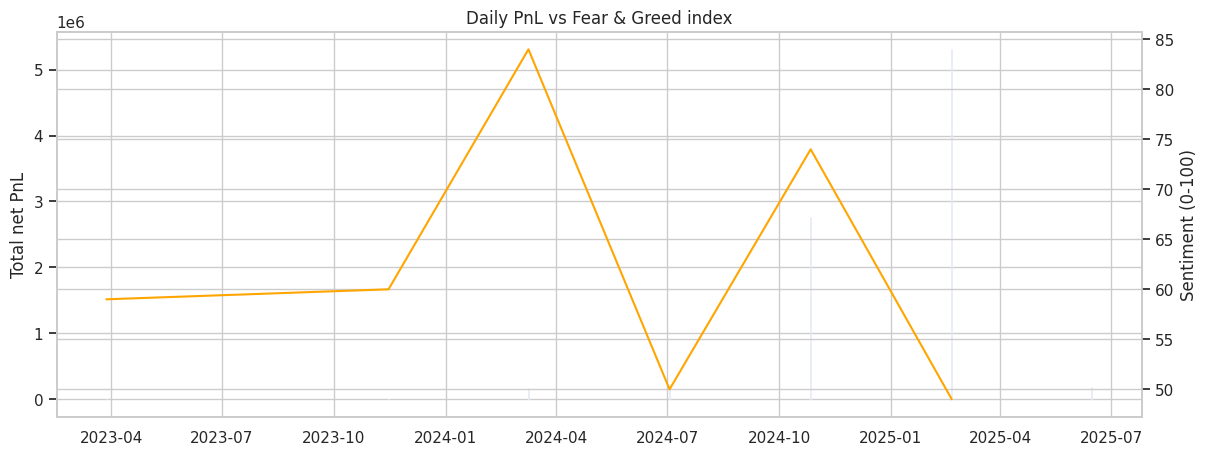

In [144]:
fig, ax1 = plt.subplots(figsize=(14,5))
ax1.bar(daily['trade_date'], daily['total_net_pnl'], alpha=0.6, label='total pnl')
ax1.set_ylabel('Total net PnL')

ax2 = ax1.twinx()
ax2.plot(daily['trade_date'], daily['value'], color='orange', label='Fear-Greed Value')
ax2.set_ylabel('Sentiment (0-100)')

ax1.set_title('Daily PnL vs Fear & Greed index')


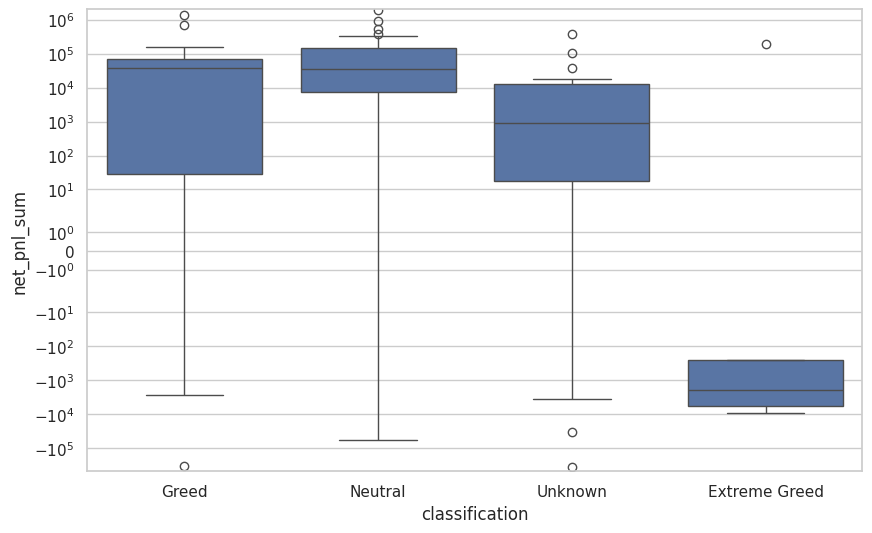

In [145]:
plt.figure(figsize=(10,6))
sns.boxplot(x='classification', y='net_pnl_sum', data=acct_day)
plt.yscale('symlog') # optional to handle heavy tails
